<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/WrapUp/sslife_stockprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

보험 섹터 대장주 선정 → 시계열 분석 & 예측 실습

In [1]:
import sys
import subprocess

def pip_install(packages):
    import importlib
    for pkg in packages:
        try:
            importlib.import_module(pkg)
        except Exception:
            print(f"Installing {pkg} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# 필요한 라이브러리 (설치 안 된 경우 설치)
pip_install(["yfinance","pandas","numpy","matplotlib","scikit-learn","pmdarima","xgboost","statsmodels","ta"])

# 라이브러리 로드
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL        # 시계열 분해를 위해 사용
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import joblib
import datetime
import pmdarima as pm                           # auto_arima를 위해 사용

plt.rcParams["figure.figsize"] = (10,6)         # Matplotlib의 기본 그림 크기를 설정

Installing scikit-learn ...
Installing pmdarima ...
Installing ta ...


In [2]:
# ------------- 사용자 설정 ----------------
# 기본 후보 리스트(필요하면 여기에 종목 추가/제거)
# Yahoo/시장에서 한국 주식은 티커 뒤에 ".KS" 또는 ".KQ"를 붙입니다.
candidates = {
    "삼성생명": "032830.KS",
    "삼성화재": "000810.KS",
    "한화생명": "088350.KS",
    "메리츠화재": "000060.KS",
    "DB손해보험": "005830.KS"
}

start_date = "2018-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
forecast_horizon = 30  # 예측 일수 (향후 30거래일)
# ------------------------------------------

In [3]:
# 1) 데이터 수집: 종가 + (가능하면) 시가총액 가져와서 대장주 선정
info_list = {}
price_data = {}

for name, ticker in candidates.items():
    print(f"Downloading {name} ({ticker}) ...")
    t = yf.Ticker(ticker)
    # price (일봉)
    df = t.history(start=start_date, end=end_date, auto_adjust=False)       # yf.Ticker(ticker).history(...)로 일별 시세를 다운로드.
    if df.empty:
        print(f"Warning: {ticker} 데이터 없음")
        continue
    # 기본 컬럼 통일: Date 인덱스, Adj Close 사용 권장하지만 한국 주식은 adjusted가 복잡할 수 있어 Close도 같이 사용
    df = df[['Open','High','Low','Close','Volume','Dividends','Stock Splits']].copy()
    price_data[name] = df
    # 시가총액(marketCap) 시도(안되는 경우가 있어 safely)
    info = {}
    try:
        info = t.info               # t.info에 시가총액(marketCap) 같은 메타정보가 있으면 저장
        info_list[name] = {
            "longName": info.get("longName"),
            "marketCap": info.get("marketCap")
        }
    except Exception:
        info_list[name] = {"longName": None, "marketCap": None}

ERROR:yfinance:$000060.KS: possibly delisted; no timezone found


In [4]:
# 2) 대장주 선정: 시가총액(max) 기준(정보 없으면 종가*주식수 계산 불가하므로 종가 기준 대체 가능)
market_caps = {n: (info_list[n].get("marketCap") if n in info_list else None) for n in price_data.keys()}
# 가능한 항목만 고려
available_caps = {n:c for n,c in market_caps.items() if c is not None}
if available_caps:
    leader = max(available_caps.items(), key=lambda x:x[1])[0]
else:
    # fallback: 최근 평균 시가(종가)로 선택
    avg_prices = {n:price_data[n]['Close'].tail(60).mean() for n in price_data.keys()}
    leader = max(avg_prices.items(), key=lambda x:x[1])[0]

print(f"\n선정된 대장주: {leader}")


선정된 대장주: 삼성생명


/tmp/ipython-input-1881619483.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].interpolate(method='time', inplace=True)  # 시간 보간으로 결측값을 채움(휴장일이 많지 않다면 무난)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fi

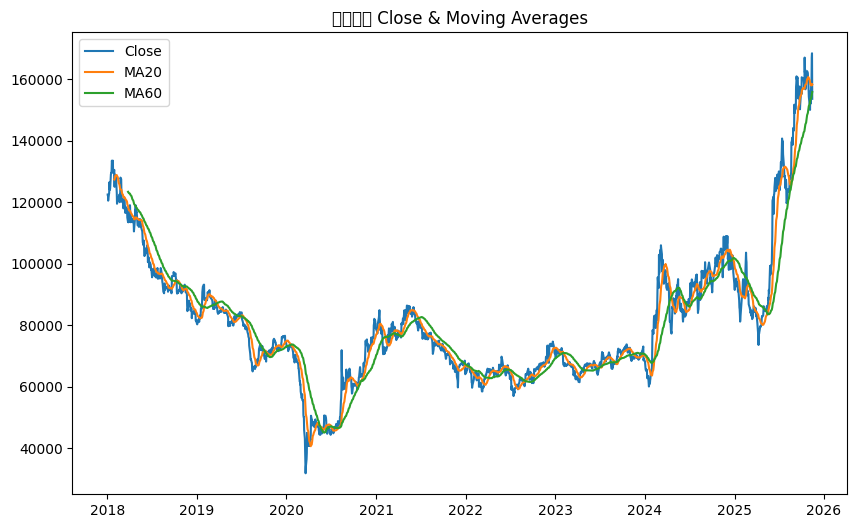

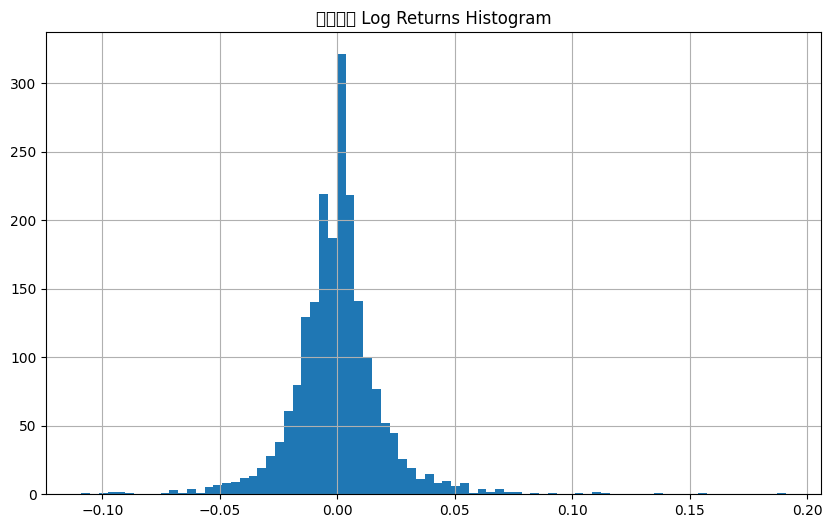

In [5]:
# 3) EDA: 종가, 로그수익률, 이동평균, 변동성
df = price_data[leader].copy()
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')  # 영업일 주기(휴장일은 NaN)
df['Close'].interpolate(method='time', inplace=True)  # 시간 보간으로 결측값을 채움(휴장일이 많지 않다면 무난)

df['log_ret'] = np.log(df['Close']).diff()      # 금융시계열에서 로그수익률은 누적이 단순해 유용
df['ret'] = df['Close'].pct_change()            # 단순수익률
df['MA20'] = df['Close'].rolling(20).mean()     # 이동평균(20일) — 추세 파악용
df['MA60'] = df['Close'].rolling(60).mean()     # 이동평균(60일) — 추세 파악용
df['vol20'] = df['log_ret'].rolling(20).std() * np.sqrt(252)    # 연환산 변동성(20일 표준편차 × sqrt(252)), 금융에서 흔히 사용

# plot price and moving averages
plt.figure()
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA60'], label='MA60')
plt.title(f"{leader} Close & Moving Averages")
plt.legend()
plt.show()

# plot returns histogram
plt.figure()
df['log_ret'].dropna().hist(bins=80)
plt.title(f"{leader} Log Returns Histogram")
plt.show()

/tmp/ipython-input-2270554733.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stl = STL(df['Close'].fillna(method='ffill'), period=252)  # 연간 주기(영업일 기준 대략 252거래일). 보험주에 명확한 연간 계절성이 없을 수도 있으니 적절히 조정 가능.
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HAN

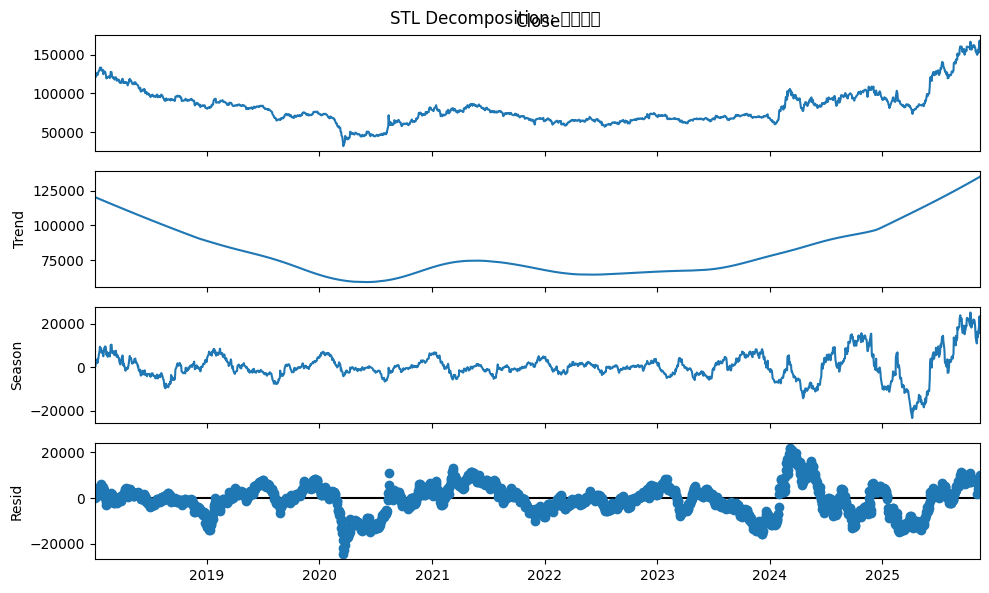

In [9]:
# 4) 시계열 분해 (STL)
stl = STL(df['Close'].fillna(method='ffill'), period=252)  # 연간 주기(영업일 기준 대략 252거래일). 보험주에 명확한 연간 계절성이 없을 수도 있으니 적절히 조정 가능.
res = stl.fit()
fig = res.plot()
plt.suptitle(f"STL Decomposition: {leader}")
plt.show()

In [6]:
# 5) 예측용 데이터 준비 (머신러닝)
# 사용할 타깃: 다음날 Close (shift -1)
data = df[['Close','ret','log_ret','MA20','MA60','vol20']].copy()

# 기술지표(간단한 추가) - 라그(lag) 및 롤링 통계
for lag in [1,2,3,5,10]:
    data[f'lag_{lag}'] = data['Close'].shift(lag)       # lag_1 등은 이전 종가를 그대로 특성으로 사용
for w in [5,10,20]:
    data[f'roll_mean_{w}'] = data['Close'].rolling(w).mean()
    data[f'roll_std_{w}'] = data['Close'].rolling(w).std()

# 타깃 변수
data['target'] = data['Close'].shift(-1)    # 다음 영업일 종가 예측
data = data.dropna()                        # 라그와 롤링 계산 때문에 생기는 NaN을 제거

# 시계열형 train/test 분할
train_frac = 0.8        # 시계열 데이터이므로 시간 순서를 유지한 채 앞쪽 80%를 훈련, 뒤쪽 20%를 테스트로 분할
train_n = int(len(data)*train_frac)
train = data.iloc[:train_n]
test = data.iloc[train_n:]

X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1595, Test samples: 399


In [10]:
# 6) 모델 A: 자동 ARIMA (pmdarima)
# ARIMA은 시계열(단일 시리즈)에서 직접 학습
series = df['Close'].dropna()
# train series for ARIMA
arima_train = series.iloc[:int(len(series)*train_frac)]
print("Fitting auto_arima (this may take time)...")
arima_model = pm.auto_arima(arima_train, seasonal=False, suppress_warnings=True, stepwise=True, error_action='ignore')      # 계절성 ARIMA를 사용하지 않음
print("ARIMA order:", arima_model.order)

# forecast with ARIMA for horizon = len(test)
arima_forecast = arima_model.predict(n_periods=len(test))
# align with test index
arima_pred_series = pd.Series(arima_forecast, index=test.index)

Fitting auto_arima (this may take time)...
ARIMA order: (1, 1, 2)


In [7]:
# 7) 모델 B: RandomForest (머신러닝 회귀)
rf = RandomForestRegressor(n_estimators=200, random_state=42)       # RandomForestRegressor는 특성-타깃 매핑을 학습하는 비선형 모델. 장점: 특성 스케일링이 크게 필요 없고, 피처 중요도 제공. 여기서는 기본 하이퍼파라미터(200트리)로 학습 — 성능 개선을 위해 GridSearch 또는 TimeSeriesSplit 기반 튜닝 권장.
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_series = pd.Series(rf_pred, index=X_test.index)

In [15]:
# ARIMA 예측값에 NaN이 생기는 문제 해결
print("NaN in y_test:", y_test.isna().sum())
print("NaN in arima_pred_series:", arima_pred_series.isna().sum())

# 인덱스 비교
print(y_test.index[:5])
print(arima_pred_series.index[:5])

NaN in y_test: 0
NaN in arima_pred_series: 11
DatetimeIndex(['2024-05-06 00:00:00+09:00', '2024-05-07 00:00:00+09:00',
               '2024-05-08 00:00:00+09:00', '2024-05-09 00:00:00+09:00',
               '2024-05-10 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Seoul]', name='Date', freq='B')
DatetimeIndex(['2024-05-06 00:00:00+09:00', '2024-05-07 00:00:00+09:00',
               '2024-05-08 00:00:00+09:00', '2024-05-09 00:00:00+09:00',
               '2024-05-10 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Seoul]', name='Date', freq='B')


In [16]:
# 예측 구간 길이 맞추기: ARIMA 예측값의 인덱스를 test 인덱스와 강제로 맞추기
# 인덱스 재정렬
arima_pred_series = arima_pred_series.reindex(y_test.index)

# NaN 제거
arima_pred_series = arima_pred_series.fillna(method="bfill").fillna(method="ffill")

/tmp/ipython-input-2259211245.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_pred_series = arima_pred_series.fillna(method="bfill").fillna(method="ffill")


In [17]:
# 8) 평가 함수
def evaluate(y_true, y_pred, name="model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))          # RMSE: 제곱오차의 제곱근(오차 크기 민감).
    mae = mean_absolute_error(y_true, y_pred)                   # MAE: 절대오차 평균(해석이 직관적)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    # MAPE: 백분율 오차(단, 실제값이 0 근처일 때 왜곡). 주식 가격에서는 하한 0 때문에 작은 값에서 과대평가될 수 있음.
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return {"rmse":rmse,"mae":mae,"mape":mape}

print("\nEvaluation on test set:")                              # 두 모델(ARIMA, RF)에 대해 평가함.
res_arima = evaluate(y_test, arima_pred_series, "ARIMA")
res_rf = evaluate(y_test, rf_pred_series, "RandomForest")


Evaluation on test set:
ARIMA -> RMSE: 38174.7371, MAE: 28919.7022, MAPE: 23.63%
RandomForest -> RMSE: 16494.1136, MAE: 9198.4108, MAPE: 6.71%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


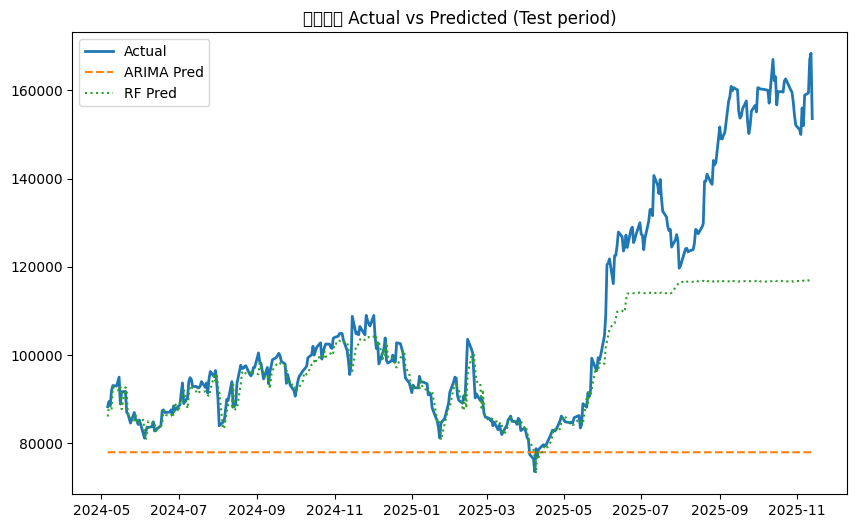

In [18]:
# 9) 시각화: 실제 vs 예측
plt.figure()                                                    # 테스트 기간 동안 실제 종가와 두 모델의 예측을 한 그래프로 비교.
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(arima_pred_series.index, arima_pred_series.values, label='ARIMA Pred', linestyle='--')
plt.plot(rf_pred_series.index, rf_pred_series.values, label='RF Pred', linestyle=':')
plt.title(f"{leader} Actual vs Predicted (Test period)")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


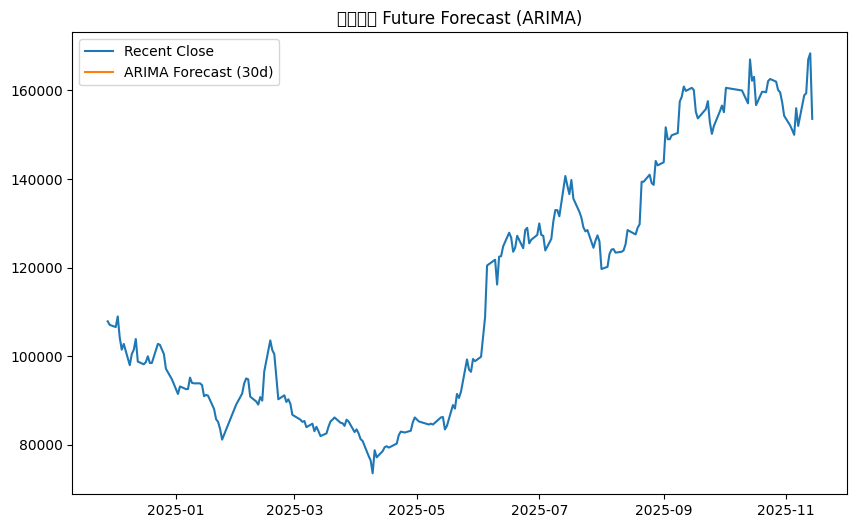

In [21]:
# 10) 향후 N일 예측 (간단한 방법)
# - ARIMA는 시계열 단일 변수 기반으로 직접 향후 horizon 예측 가능. 주의: ARIMA의 향후 예측은 오차 누적과 모델 한계(외부 변수 반영 불가)로 인해 불확실성이 존재.
future_arima = arima_model.predict(n_periods=forecast_horizon)
last_date = df.index.max()
future_index = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon)   # future_index를 비즈니스 데이(영업일)로 생성하여 예측 결과에 날짜 인덱스를 부여.
future_arima_series = pd.Series(future_arima, index=future_index)

plt.figure()
plt.plot(df['Close'].iloc[-252:], label='Recent Close')
plt.plot(future_arima_series, label=f'ARIMA Forecast ({forecast_horizon}d)')
plt.title(f"{leader} Future Forecast (ARIMA)")
plt.legend()
plt.show()

In [22]:
# 11) 결과 저장
out_df = pd.DataFrame({
    "actual_test": y_test,
    "arima_pred": arima_pred_series,
    "rf_pred": rf_pred_series
})
out_df.to_csv(f"{leader}_test_results.csv")
future_arima_series.to_csv(f"{leader}_future_ARIMA.csv")
print("Results saved to CSV.")

Results saved to CSV.


In [ ]:
# 12) 모델 저장(선택)
joblib.dump(rf, f"{leader}_rf_model.joblib")            # joblib.dump로 학습된 모델을 파일로 저장하여 재사용 가능(예: 배포, 재예측).
joblib.dump(arima_model, f"{leader}_arima_model.joblib")
print("Models saved.")

# 끝